In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import psutil


class VAE(nn.Module):
    def __init__(self, latent_dim=200):
        super(VAE, self).__init__()

        # Encoder: 4 Conv2d layers with stride=2, kernel=4, padding=1
        # Input: (3, 64, 64) -> (32, 32, 32) -> (64, 16, 16) -> (128, 8, 8) -> (256, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # 0
            nn.ReLU(),                                                # 1
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                # 3
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 4
            nn.ReLU(),                                                # 5
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 6
            nn.ReLU(),                                                # 7
        )

        # 256 * 4 * 4 = 4096
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 4096)

        # Decoder: 4 ConvTranspose2d layers
        # (256, 4, 4) -> (128, 8, 8) -> (64, 16, 16) -> (32, 32, 32) -> (3, 64, 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 0
            nn.ReLU(),                                                          # 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2
            nn.ReLU(),                                                          # 3
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 4
            nn.ReLU(),                                                          # 5
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 6
            nn.Sigmoid(),                                                       # 7
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 4096)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to (batch, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW

# --- PassportHook for DDPM ---

class PassportHook:
    """Hook that applies passport transformation: alpha * output + beta"""

    def __init__(self, conv_layer, passport_activation):
        """
        Args:
            conv_layer: The conv layer module (to get weights)
            passport_activation: Fixed activation from passport [1, C, H, W]
        """
        self.conv_layer = conv_layer
        self.passport_activation = passport_activation.clone()
        self.hook = None

        # Ensure passport is 4D [1, C, H, W]
        if len(self.passport_activation.shape) == 3:
            self.passport_activation = self.passport_activation.unsqueeze(0)

    def compute_alpha_beta(self, output_shape=None):
        """
        Compute alpha and beta using conv weights and passport activation
        alpha = avg(conv(passport_activation))
        beta = avg(conv(passport_activation))
        """
        conv_weights = self.conv_layer.weight

        # Apply convolution: conv(passport_activation)
        conv_result = F.conv2d(
            self.passport_activation,
            conv_weights,
            bias=None,
            stride=self.conv_layer.stride,
            padding=self.conv_layer.padding,
            dilation=self.conv_layer.dilation
        )  # [1, out_channels, H_out, W_out]

        # Compute average pooling
        alpha = torch.mean(conv_result, dim=(2, 3), keepdim=True)  # [1, out_channels, 1, 1]
        beta = torch.mean(conv_result, dim=(2, 3), keepdim=True)

        return alpha, beta

    def hook_fn(self, module, input, output):
        """Apply passport transformation: alpha * output + beta"""
        alpha, beta = self.compute_alpha_beta(output.shape)
        alpha = alpha.to(output.device)
        beta = beta.to(output.device)
        transformed_output = alpha * output + beta
        return transformed_output

    def register(self, module):
        """Register the hook to the module"""
        self.hook = module.register_forward_hook(self.hook_fn)

    def remove(self):
        """Remove the hook"""
        if self.hook:
            self.hook.remove()


# --- Classe Principale Passport DDPM ---

class PassportVAE:
    def __init__(self, model, device="cuda"):
        self.device = device
        self.model= model

        # Configuration par defaut
        self.config = {
            "layer_name": "decoder.6",  # Couche cible (sans .weight)
            "lr": 1e-4,
            "lambda_wat": 1.0,
            "epochs": 10,
            "gamma": 0.1,
            "beta_kl":1.0# Sign loss parameter
        }

        self.saved_keys = {}

    def _get_layer(self, model, layer_name):
        """Navigate to a layer by its path (e.g., 'mid_block.resnets.0.conv1')"""
        layer = model
        for part in layer_name.split('.'):
            if part.isdigit():
                layer = layer[int(part)]
            else:
                layer = getattr(layer, part)
        return layer

    def _generate_passport_activation(self, model):
        """
        Generate passport activation by running a trigger input through the model
        and capturing the activation at the target layer.
        """
        # Create a fixed trigger input
        trigger_noise = torch.randn(1, 3, 64, 64).to(self.device)


        # Get target layer
        target_layer = self._get_layer(model, self.config["layer_name"])

        # Hook to capture activation
        activation = {}
        def capture_hook(module, input, output):
            activation['output'] = output.clone()  # Capture input to this layer

        hook = target_layer.register_forward_hook(capture_hook)

        # Forward pass
        with torch.no_grad():
            _ = model(trigger_noise)

        hook.remove()

        return activation['output'], trigger_noise

    @staticmethod
    def _sign_loss(watermark, alpha, gamma=0.1):
        """
        Compute sign loss R(P, B) = sum_i max(gamma - alpha_i * b_i, 0)
        Forces alpha signs to match watermark.
        """
        if alpha.dim() > 1:
            alpha = alpha.view(-1)
        watermark = watermark.view(-1)

        if not torch.is_tensor(gamma):
            gamma = torch.tensor(gamma, dtype=alpha.dtype, device=alpha.device)

        values = gamma - alpha * watermark
        R = torch.sum(torch.clamp(values, min=0))
        return R

    @staticmethod
    def _check_sign_match(alpha, watermark):
        """Check how many signs match between alpha and watermark"""
        if alpha.dim() > 1:
            alpha = alpha.view(-1)
        alpha_signs = torch.sign(alpha)
        matches = (alpha_signs == watermark).float()
        accuracy = torch.mean(matches).item()
        return accuracy, alpha_signs

    def embed(self, dataloader):
        """
        Incorpore la marque Passport pendant le finetuning.
        Le watermark est encode dans les signes de alpha.
        """
        print(f"--- Demarrage Embedding Passport ({self.config['layer_name']}) ---")

        # 1. Preparation
        watermarked_model = self.model
        watermarked_model.train()

        # 2. Generate passport activation
        passport_activation, trigger_noise= self._generate_passport_activation(watermarked_model)
        print(f"Passport activation shape: {passport_activation.shape}")

        # 3. Get target layer and create hook
        target_layer = self._get_layer(watermarked_model, self.config["layer_name"])
        passport_hook = PassportHook(target_layer, passport_activation)

        # 4. Generate watermark (binary {-1, +1})
        out_channels = target_layer.weight.shape[0]
        watermark = torch.randint(0, 2, (out_channels,), dtype=torch.float32).to(self.device) * 2 - 1
        print(f"Watermark size: {len(watermark)} | First 10: {watermark[:10].tolist()}")

        # 5. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_model.parameters(), lr=self.config["lr"])
        mse_loss = nn.MSELoss()

        gamma = self.config["gamma"]

        # 6. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader)
            for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)

                optimizer.zero_grad()

                # B. Prediction (Task Loss)
                recon, mu, logvar = watermarked_model(clean_images)

                # Reconstruction loss
                l_recon = F.mse_loss(recon, clean_images)

                # KL divergence
                l_kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # VAE total task loss
                l_main = l_recon + self.config["beta_kl"] * l_kl

                # C. Sign Loss (Passport)
                alpha, beta = passport_hook.compute_alpha_beta()
                l_sign = self._sign_loss(watermark, alpha, gamma)

                # Loss Totale
                l_total = l_main + self.config["lambda_wat"] * l_sign

                l_total.backward()
                optimizer.step()

                # Metrics
                sign_acc, alpha_signs = self._check_sign_match(alpha, watermark)
                ber = 1.0 - sign_acc
                pbar.set_description(
                    f"Epoch {epoch+1} | L_Main: {l_main:.3f} | L_Sign: {l_sign:.3f} | BER: {ber:.2f}"
                )

            #     if ber == 0.0 and l_sign.item() < 0.01:
            #         print("Convergence atteinte !")
            #         break
            # if ber == 0.0:
            #     break

        # Sauvegarde des cles
        self.saved_keys = {
            "watermark": watermark,
            "watermarked_model": watermarked_model,
            "passport_activation": passport_activation,
            "passport_hook": passport_hook,
            "trigger_noise": trigger_noise,

        }
        torch.save(self.saved_keys, "passport_VAE_model_checkpoint.pt")
        return watermarked_model

    def extract(self, model=None):
        """
        Extrait la marque d'un modele suspect en verifiant les signes de alpha.
        """
        if model is None:
            modle = self.saved_keys["watermarked_model"]

        watermark = self.saved_keys["watermark"]
        passport_activation = self.saved_keys["passport_activation"]

        # Get target layer from suspect model
        target_layer = self._get_layer(model, self.config["layer_name"])

        # Create new hook with same passport activation
        suspect_hook = PassportHook(target_layer, passport_activation)

        # Compute alpha
        with torch.no_grad():
            alpha, beta = suspect_hook.compute_alpha_beta()
            sign_acc, alpha_signs = self._check_sign_match(alpha, watermark)
            ber = 1.0 - sign_acc

        print(f"BER Extrait : {ber:.2f}")
        return ber, alpha_signs

    @staticmethod
    def _compute_ber(alpha_signs, watermark):
        return ((alpha_signs != watermark).float()).mean().item()


/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

import os
import torch
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load from Hugging Face (no Google Drive issues)
print("Loading dataset...")


from datasets import load_from_disk
hf_dataset = load_from_disk("celeba_local")
# os.makedirs("./celeba_images/all", exist_ok=True)
# for i, item in enumerate(hf_dataset):
#     item['image'].save(f"./celeba_images/all/{i:06d}.jpg")
# del hf_dataset


class CelebAWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image, 0

dataset = CelebAWrapper(hf_dataset, transform)
# del hf_dataset
# gc.collect()
# dataset = datasets.ImageFolder("./celeba_images", transform=transform)
print("Dataset loaded!")

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("loader loaded!")


Loading dataset...
Dataset loaded!
loader loaded!


In [4]:
#load model
latent_dim = 200

# Initialize the model
model = VAE(latent_dim=latent_dim)

# Load the trained weights
model_path = "./vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)


# 2. Embedding Passport
passport_defense = PassportVAE(model, device=device)
watermarked_model = passport_defense.embed(dataloader)

--- Demarrage Embedding Passport (decoder.6) ---
Passport activation shape: torch.Size([1, 3, 64, 64])
Watermark size: 32 | First 10: [-1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0]


Epoch 1 | L_Main: 0.319 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [01:59<00:00, 26.39it/s]
Epoch 2 | L_Main: 0.319 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:05<00:00, 25.14it/s]
Epoch 3 | L_Main: 0.320 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:08<00:00, 24.57it/s]
Epoch 4 | L_Main: 0.338 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:15<00:00, 23.28it/s]
Epoch 5 | L_Main: 0.313 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:09<00:00, 24.37it/s]
Epoch 6 | L_Main: 0.301 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:04<00:00, 25.48it/s]
Epoch 7 | L_Main: 0.318 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:01<00:00, 26.04it/s]
Epoch 8 | L_Main: 0.314 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [02:07<00:00, 24.81it/s]
Epoch 9 | L_Main: 0.266 | L_Sign: 0.000 | BER: 0.00: 100%|██████████| 3166/3166 [01:26<00:00, 36.80it/s]
Epoch 10 | L_Main: 0.306 | L_Sign: 0.000 | BER: 0.00: 1

In [5]:
# 3. Extraction (Test immediat)
ber, _ = passport_defense.extract(watermarked_model)
print(f"\nResultat final - BER: {ber:.2f}")

BER Extrait : 0.00

Resultat final - BER: 0.00


In [6]:
passport_defense.saved_keys

{'watermark': tensor([-1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,
          1.,  1.,  1.,  1.], device='cuda:0'),
 'watermarked_model': VAE(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (3): ReLU()
     (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): ReLU()
     (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (7): ReLU()
   )
   (fc_mu): Linear(in_features=4096, out_features=200, bias=True)
   (fc_logvar): Linear(in_features=4096, out_features=200, bias=True)
   (decoder_input): Linear(in_features=200, out_features=4096, bias=True)
   (decoder): Sequential(
     (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
     (2):

In [7]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack_passport(passport_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transferer la fonctionnalite du modele Passport vers un modele vierge.
    Verifie si la marque (basee sur les signes de alpha) survit.
    """
    device = passport_obj.device
    checkpoint = torch.load("passport_VAE_model_checkpoint.pt", weights_only=False)


    # 1. Teacher (Gele)
    teacher = checkpoint["watermarked_model"]
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Meme architecture)
    print("\n--- Initialisation du Student ---")
    student=VAE(latent_dim=latent_dim)
    student.load_state_dict(torch.load(model_path))
    student.to(device)
    student.train()

    teacher_ber, _ = passport_obj.extract(teacher)
    student_ber, _ = passport_obj.extract(student)
    # Sanity Checks
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")

    optimizer = AdamW(student.parameters(), lr=lr)

    history = {"loss": [], "ber": []}

    print(f"\n--- Distillation Passport ({epochs} epochs) ---")
    a=0
    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)


            # B. Distillation (Output Matching)
            with torch.no_grad():
                 target_pred,_,_ = teacher(clean_images)

            student_pred,_,_ = student(clean_images)

            loss = F.mse_loss(student_pred, target_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        # C. Verification
        current_ber, alpha_signs = passport_obj.extract(student)
        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))

        print(f"Fin Epoch {epoch+1} | Loss: {history['loss'][-1]:.4f} | BER Student: {current_ber:.2f} err_wat: {nn.BCELoss()((alpha_signs+1)/2, (checkpoint["watermark"]+1)/2).item()}")
        if current_ber==0.0 and a>=1:
            print("✅ Marque récupérée avec succès par distillation !")
            break
        elif current_ber==0.0 and a<1 :
            a+=1
        else:
            a=0
    return student, history


In [8]:
# 4. Attaque par Distillation
student_res, stats = run_distillation_attack_passport(passport_defense, dataloader, epochs=100)


--- Initialisation du Student ---
BER Extrait : 0.00
BER Extrait : 0.47
[Check] BER Teacher: 0.00
[Check] BER Student (Avant): 0.47

--- Distillation Passport (100 epochs) ---


Epoch 1: 100%|██████████| 3166/3166 [01:26<00:00, 36.51it/s, Loss=0.00654]


BER Extrait : 0.44
Fin Epoch 1 | Loss: 0.0080 | BER Student: 0.44 err_wat: 43.75


Epoch 2: 100%|██████████| 3166/3166 [01:23<00:00, 37.73it/s, Loss=0.00565]


BER Extrait : 0.44
Fin Epoch 2 | Loss: 0.0068 | BER Student: 0.44 err_wat: 43.75


Epoch 3: 100%|██████████| 3166/3166 [01:25<00:00, 37.06it/s, Loss=0.00689]


BER Extrait : 0.47
Fin Epoch 3 | Loss: 0.0067 | BER Student: 0.47 err_wat: 46.875


Epoch 4: 100%|██████████| 3166/3166 [01:26<00:00, 36.68it/s, Loss=0.00642]


BER Extrait : 0.47
Fin Epoch 4 | Loss: 0.0067 | BER Student: 0.47 err_wat: 46.875


Epoch 5: 100%|██████████| 3166/3166 [01:23<00:00, 38.06it/s, Loss=0.00525]


BER Extrait : 0.44
Fin Epoch 5 | Loss: 0.0067 | BER Student: 0.44 err_wat: 43.75


Epoch 6: 100%|██████████| 3166/3166 [01:23<00:00, 37.78it/s, Loss=0.00761]


BER Extrait : 0.44
Fin Epoch 6 | Loss: 0.0066 | BER Student: 0.44 err_wat: 43.75


Epoch 7: 100%|██████████| 3166/3166 [01:22<00:00, 38.15it/s, Loss=0.00622]


BER Extrait : 0.41
Fin Epoch 7 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 8: 100%|██████████| 3166/3166 [01:24<00:00, 37.65it/s, Loss=0.00554]


BER Extrait : 0.38
Fin Epoch 8 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 9: 100%|██████████| 3166/3166 [01:23<00:00, 37.99it/s, Loss=0.00747]


BER Extrait : 0.41
Fin Epoch 9 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 10: 100%|██████████| 3166/3166 [01:23<00:00, 37.90it/s, Loss=0.00789]


BER Extrait : 0.41
Fin Epoch 10 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 11: 100%|██████████| 3166/3166 [01:23<00:00, 37.81it/s, Loss=0.00669]


BER Extrait : 0.41
Fin Epoch 11 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 12: 100%|██████████| 3166/3166 [01:24<00:00, 37.67it/s, Loss=0.00529]


BER Extrait : 0.41
Fin Epoch 12 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 13: 100%|██████████| 3166/3166 [01:23<00:00, 37.83it/s, Loss=0.00519]


BER Extrait : 0.38
Fin Epoch 13 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 14: 100%|██████████| 3166/3166 [01:24<00:00, 37.64it/s, Loss=0.00685]


BER Extrait : 0.41
Fin Epoch 14 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 15: 100%|██████████| 3166/3166 [01:23<00:00, 37.88it/s, Loss=0.00791]


BER Extrait : 0.41
Fin Epoch 15 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 16: 100%|██████████| 3166/3166 [01:23<00:00, 37.92it/s, Loss=0.00511]


BER Extrait : 0.38
Fin Epoch 16 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 17: 100%|██████████| 3166/3166 [01:22<00:00, 38.17it/s, Loss=0.00503]


BER Extrait : 0.34
Fin Epoch 17 | Loss: 0.0066 | BER Student: 0.34 err_wat: 34.375


Epoch 18: 100%|██████████| 3166/3166 [01:23<00:00, 37.92it/s, Loss=0.00471]


BER Extrait : 0.41
Fin Epoch 18 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 19: 100%|██████████| 3166/3166 [01:23<00:00, 38.05it/s, Loss=0.00581]


BER Extrait : 0.34
Fin Epoch 19 | Loss: 0.0066 | BER Student: 0.34 err_wat: 34.375


Epoch 20: 100%|██████████| 3166/3166 [01:23<00:00, 37.84it/s, Loss=0.00753]


BER Extrait : 0.34
Fin Epoch 20 | Loss: 0.0066 | BER Student: 0.34 err_wat: 34.375


Epoch 21: 100%|██████████| 3166/3166 [01:23<00:00, 37.82it/s, Loss=0.00578]


BER Extrait : 0.38
Fin Epoch 21 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 22: 100%|██████████| 3166/3166 [01:23<00:00, 37.93it/s, Loss=0.00578]


BER Extrait : 0.38
Fin Epoch 22 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 23: 100%|██████████| 3166/3166 [01:23<00:00, 37.93it/s, Loss=0.00765]


BER Extrait : 0.38
Fin Epoch 23 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 24: 100%|██████████| 3166/3166 [01:23<00:00, 37.88it/s, Loss=0.00658]


BER Extrait : 0.38
Fin Epoch 24 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 25: 100%|██████████| 3166/3166 [01:24<00:00, 37.50it/s, Loss=0.00763]


BER Extrait : 0.38
Fin Epoch 25 | Loss: 0.0066 | BER Student: 0.38 err_wat: 37.5


Epoch 26: 100%|██████████| 3166/3166 [01:22<00:00, 38.16it/s, Loss=0.0082] 


BER Extrait : 0.41
Fin Epoch 26 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 27: 100%|██████████| 3166/3166 [01:24<00:00, 37.69it/s, Loss=0.00676]


BER Extrait : 0.34
Fin Epoch 27 | Loss: 0.0066 | BER Student: 0.34 err_wat: 34.375


Epoch 28: 100%|██████████| 3166/3166 [01:23<00:00, 37.82it/s, Loss=0.00636]


BER Extrait : 0.41
Fin Epoch 28 | Loss: 0.0065 | BER Student: 0.41 err_wat: 40.625


Epoch 29: 100%|██████████| 3166/3166 [01:24<00:00, 37.66it/s, Loss=0.00663]


BER Extrait : 0.41
Fin Epoch 29 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 30: 100%|██████████| 3166/3166 [01:23<00:00, 37.79it/s, Loss=0.00704]


BER Extrait : 0.44
Fin Epoch 30 | Loss: 0.0066 | BER Student: 0.44 err_wat: 43.75


Epoch 31: 100%|██████████| 3166/3166 [01:24<00:00, 37.47it/s, Loss=0.0068] 


BER Extrait : 0.41
Fin Epoch 31 | Loss: 0.0066 | BER Student: 0.41 err_wat: 40.625


Epoch 32: 100%|██████████| 3166/3166 [01:23<00:00, 37.74it/s, Loss=0.00539]


BER Extrait : 0.44
Fin Epoch 32 | Loss: 0.0066 | BER Student: 0.44 err_wat: 43.75


Epoch 33: 100%|██████████| 3166/3166 [01:24<00:00, 37.37it/s, Loss=0.00897]


BER Extrait : 0.47
Fin Epoch 33 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 34: 100%|██████████| 3166/3166 [01:24<00:00, 37.61it/s, Loss=0.00712]


BER Extrait : 0.47
Fin Epoch 34 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 35: 100%|██████████| 3166/3166 [01:24<00:00, 37.56it/s, Loss=0.0065] 


BER Extrait : 0.47
Fin Epoch 35 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 36: 100%|██████████| 3166/3166 [01:24<00:00, 37.53it/s, Loss=0.00694]


BER Extrait : 0.47
Fin Epoch 36 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 37: 100%|██████████| 3166/3166 [01:24<00:00, 37.64it/s, Loss=0.00803]


BER Extrait : 0.47
Fin Epoch 37 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 38: 100%|██████████| 3166/3166 [01:24<00:00, 37.34it/s, Loss=0.0075] 


BER Extrait : 0.47
Fin Epoch 38 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 39: 100%|██████████| 3166/3166 [01:24<00:00, 37.67it/s, Loss=0.00858]


BER Extrait : 0.47
Fin Epoch 39 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 40: 100%|██████████| 3166/3166 [01:24<00:00, 37.38it/s, Loss=0.00892]


BER Extrait : 0.47
Fin Epoch 40 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 41: 100%|██████████| 3166/3166 [01:23<00:00, 37.74it/s, Loss=0.00723]


BER Extrait : 0.47
Fin Epoch 41 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 42: 100%|██████████| 3166/3166 [01:24<00:00, 37.63it/s, Loss=0.00635]


BER Extrait : 0.47
Fin Epoch 42 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 43: 100%|██████████| 3166/3166 [01:23<00:00, 37.71it/s, Loss=0.00672]


BER Extrait : 0.47
Fin Epoch 43 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 44: 100%|██████████| 3166/3166 [01:24<00:00, 37.69it/s, Loss=0.00716]


BER Extrait : 0.47
Fin Epoch 44 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 45: 100%|██████████| 3166/3166 [01:23<00:00, 37.84it/s, Loss=0.00657]


BER Extrait : 0.47
Fin Epoch 45 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 46: 100%|██████████| 3166/3166 [01:23<00:00, 37.87it/s, Loss=0.00785]


BER Extrait : 0.47
Fin Epoch 46 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 47: 100%|██████████| 3166/3166 [01:23<00:00, 37.70it/s, Loss=0.00545]


BER Extrait : 0.47
Fin Epoch 47 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 48: 100%|██████████| 3166/3166 [01:23<00:00, 37.97it/s, Loss=0.00726]


BER Extrait : 0.47
Fin Epoch 48 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 49: 100%|██████████| 3166/3166 [01:24<00:00, 37.54it/s, Loss=0.00777]


BER Extrait : 0.47
Fin Epoch 49 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 50: 100%|██████████| 3166/3166 [01:22<00:00, 38.16it/s, Loss=0.00772]


BER Extrait : 0.47
Fin Epoch 50 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 51: 100%|██████████| 3166/3166 [01:23<00:00, 38.03it/s, Loss=0.00756]


BER Extrait : 0.47
Fin Epoch 51 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 52: 100%|██████████| 3166/3166 [01:22<00:00, 38.15it/s, Loss=0.0054] 


BER Extrait : 0.47
Fin Epoch 52 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 53: 100%|██████████| 3166/3166 [01:23<00:00, 37.78it/s, Loss=0.0056] 


BER Extrait : 0.47
Fin Epoch 53 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 54: 100%|██████████| 3166/3166 [01:22<00:00, 38.29it/s, Loss=0.0063] 


BER Extrait : 0.47
Fin Epoch 54 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 55: 100%|██████████| 3166/3166 [01:23<00:00, 37.71it/s, Loss=0.00676]


BER Extrait : 0.47
Fin Epoch 55 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 56: 100%|██████████| 3166/3166 [01:22<00:00, 38.15it/s, Loss=0.00672]


BER Extrait : 0.47
Fin Epoch 56 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 57: 100%|██████████| 3166/3166 [01:23<00:00, 37.85it/s, Loss=0.00708]


BER Extrait : 0.44
Fin Epoch 57 | Loss: 0.0066 | BER Student: 0.44 err_wat: 43.75


Epoch 58: 100%|██████████| 3166/3166 [01:24<00:00, 37.58it/s, Loss=0.00454]


BER Extrait : 0.47
Fin Epoch 58 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 59: 100%|██████████| 3166/3166 [01:23<00:00, 37.88it/s, Loss=0.00598]


BER Extrait : 0.47
Fin Epoch 59 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 60: 100%|██████████| 3166/3166 [01:24<00:00, 37.59it/s, Loss=0.0061] 


BER Extrait : 0.47
Fin Epoch 60 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 61: 100%|██████████| 3166/3166 [01:23<00:00, 37.78it/s, Loss=0.00827]


BER Extrait : 0.47
Fin Epoch 61 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 62: 100%|██████████| 3166/3166 [01:23<00:00, 37.77it/s, Loss=0.00705]


BER Extrait : 0.47
Fin Epoch 62 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 63: 100%|██████████| 3166/3166 [01:24<00:00, 37.65it/s, Loss=0.00528]


BER Extrait : 0.47
Fin Epoch 63 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 64: 100%|██████████| 3166/3166 [01:23<00:00, 37.72it/s, Loss=0.00609]


BER Extrait : 0.47
Fin Epoch 64 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 65: 100%|██████████| 3166/3166 [01:23<00:00, 37.73it/s, Loss=0.00833]


BER Extrait : 0.47
Fin Epoch 65 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 66: 100%|██████████| 3166/3166 [01:24<00:00, 37.33it/s, Loss=0.00623]


BER Extrait : 0.47
Fin Epoch 66 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 67: 100%|██████████| 3166/3166 [01:24<00:00, 37.59it/s, Loss=0.00647]


BER Extrait : 0.44
Fin Epoch 67 | Loss: 0.0065 | BER Student: 0.44 err_wat: 43.75


Epoch 68: 100%|██████████| 3166/3166 [01:24<00:00, 37.55it/s, Loss=0.0061] 


BER Extrait : 0.47
Fin Epoch 68 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 69: 100%|██████████| 3166/3166 [01:23<00:00, 37.77it/s, Loss=0.00532]


BER Extrait : 0.44
Fin Epoch 69 | Loss: 0.0066 | BER Student: 0.44 err_wat: 43.75


Epoch 70: 100%|██████████| 3166/3166 [01:23<00:00, 37.85it/s, Loss=0.00689]


BER Extrait : 0.47
Fin Epoch 70 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 71: 100%|██████████| 3166/3166 [01:24<00:00, 37.56it/s, Loss=0.00475]


BER Extrait : 0.47
Fin Epoch 71 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 72: 100%|██████████| 3166/3166 [01:23<00:00, 37.76it/s, Loss=0.00695]


BER Extrait : 0.47
Fin Epoch 72 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 73: 100%|██████████| 3166/3166 [01:24<00:00, 37.38it/s, Loss=0.00663]


BER Extrait : 0.47
Fin Epoch 73 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 74: 100%|██████████| 3166/3166 [01:23<00:00, 37.74it/s, Loss=0.00746]


BER Extrait : 0.47
Fin Epoch 74 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 75: 100%|██████████| 3166/3166 [01:23<00:00, 37.89it/s, Loss=0.00608]


BER Extrait : 0.47
Fin Epoch 75 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 76: 100%|██████████| 3166/3166 [01:24<00:00, 37.36it/s, Loss=0.00643]


BER Extrait : 0.47
Fin Epoch 76 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 77: 100%|██████████| 3166/3166 [01:24<00:00, 37.67it/s, Loss=0.00632]


BER Extrait : 0.47
Fin Epoch 77 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 78: 100%|██████████| 3166/3166 [01:24<00:00, 37.68it/s, Loss=0.00651]


BER Extrait : 0.47
Fin Epoch 78 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 79: 100%|██████████| 3166/3166 [01:24<00:00, 37.48it/s, Loss=0.00639]


BER Extrait : 0.47
Fin Epoch 79 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 80: 100%|██████████| 3166/3166 [01:24<00:00, 37.54it/s, Loss=0.00834]


BER Extrait : 0.47
Fin Epoch 80 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 81: 100%|██████████| 3166/3166 [01:23<00:00, 37.72it/s, Loss=0.00574]


BER Extrait : 0.44
Fin Epoch 81 | Loss: 0.0065 | BER Student: 0.44 err_wat: 43.75


Epoch 82: 100%|██████████| 3166/3166 [01:24<00:00, 37.56it/s, Loss=0.00657]


BER Extrait : 0.47
Fin Epoch 82 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 83: 100%|██████████| 3166/3166 [01:24<00:00, 37.62it/s, Loss=0.00716]


BER Extrait : 0.47
Fin Epoch 83 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 84: 100%|██████████| 3166/3166 [01:24<00:00, 37.34it/s, Loss=0.00595]


BER Extrait : 0.47
Fin Epoch 84 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 85: 100%|██████████| 3166/3166 [01:24<00:00, 37.61it/s, Loss=0.00927]


BER Extrait : 0.47
Fin Epoch 85 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 86: 100%|██████████| 3166/3166 [01:23<00:00, 37.74it/s, Loss=0.00789]


BER Extrait : 0.47
Fin Epoch 86 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 87: 100%|██████████| 3166/3166 [01:24<00:00, 37.26it/s, Loss=0.00622]


BER Extrait : 0.47
Fin Epoch 87 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 88: 100%|██████████| 3166/3166 [01:24<00:00, 37.61it/s, Loss=0.00692]


BER Extrait : 0.47
Fin Epoch 88 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 89: 100%|██████████| 3166/3166 [01:24<00:00, 37.60it/s, Loss=0.00659]


BER Extrait : 0.47
Fin Epoch 89 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 90: 100%|██████████| 3166/3166 [01:24<00:00, 37.37it/s, Loss=0.00787]


BER Extrait : 0.47
Fin Epoch 90 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 91: 100%|██████████| 3166/3166 [01:23<00:00, 37.73it/s, Loss=0.00614]


BER Extrait : 0.47
Fin Epoch 91 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 92: 100%|██████████| 3166/3166 [01:24<00:00, 37.30it/s, Loss=0.00723]


BER Extrait : 0.47
Fin Epoch 92 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 93: 100%|██████████| 3166/3166 [01:24<00:00, 37.60it/s, Loss=0.00441]


BER Extrait : 0.47
Fin Epoch 93 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 94: 100%|██████████| 3166/3166 [01:24<00:00, 37.66it/s, Loss=0.00566]


BER Extrait : 0.47
Fin Epoch 94 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 95: 100%|██████████| 3166/3166 [01:23<00:00, 37.76it/s, Loss=0.00726]


BER Extrait : 0.47
Fin Epoch 95 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 96: 100%|██████████| 3166/3166 [01:24<00:00, 37.67it/s, Loss=0.0084] 


BER Extrait : 0.47
Fin Epoch 96 | Loss: 0.0066 | BER Student: 0.47 err_wat: 46.875


Epoch 97: 100%|██████████| 3166/3166 [01:24<00:00, 37.27it/s, Loss=0.00591]


BER Extrait : 0.47
Fin Epoch 97 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 98: 100%|██████████| 3166/3166 [01:23<00:00, 37.76it/s, Loss=0.00902]


BER Extrait : 0.47
Fin Epoch 98 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 99: 100%|██████████| 3166/3166 [01:24<00:00, 37.57it/s, Loss=0.00738]


BER Extrait : 0.47
Fin Epoch 99 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


Epoch 100: 100%|██████████| 3166/3166 [01:24<00:00, 37.37it/s, Loss=0.005]  

BER Extrait : 0.47
Fin Epoch 100 | Loss: 0.0065 | BER Student: 0.47 err_wat: 46.875


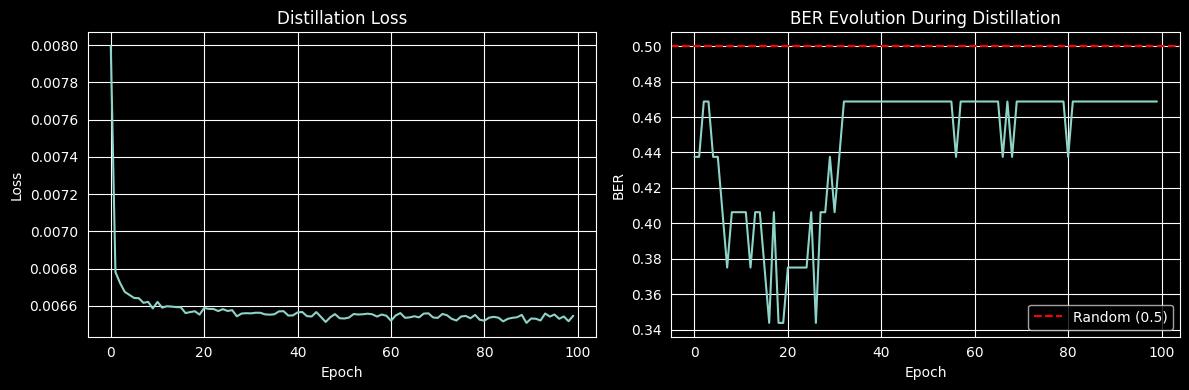

In [9]:
# 5. Visualisation des resultats
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(stats["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Distillation Loss")

ax2.plot(stats["ber"])
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random (0.5)')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("BER")
ax2.set_title("BER Evolution During Distillation")
ax2.legend()

plt.tight_layout()
plt.show()